<a href="https://colab.research.google.com/github/AndreYang333/ExplainableAI/blob/main/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI590 Assignment 3
## Minjie Yang (my189)
## Link to github: https://github.com/AndreYang333/ExplainableAI.git
## Link to colab: https://colab.research.google.com/github/AndreYang333/ExplainableAI/blob/main/Assignment3.ipynb#scrollTo=OcqK0TsHdSv0
## Link to reference code: https://github.com/AIPI-590-XAI/Duke-AI-XAI/tree/main/interpretable-ml-example-notebooks (some code are from this notebook)

Import required libraries

In [1]:
!pip install pygam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 9.3 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1


In [4]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pygam import LogisticGAM, s, f

Unzip data file and save it to the data directory. This is the link to the datafile.https://www.kaggle.com/datasets/blastchar/telco-customer-churn?resource=download


In [5]:
import zipfile
import os

zip_file_path = 'archive.zip'  # File to unload
extract_path = 'telco-customer-churn'     # File to save

# Upzip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

df = pd.read_csv('/content/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Transform the value of Churn

In [6]:
df = df.replace({'Yes': 1, 'No': 0}) # Transform all the dummy variables to 1 and 0. Yes for 1 and No for 0
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,1,0,1,0,No phone service,DSL,0,...,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,0,0,34,1,0,DSL,1,...,1,0,0,0,One year,0,Mailed check,56.95,1889.5,0
2,3668-QPYBK,Male,0,0,0,2,1,0,DSL,1,...,0,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,0,0,45,0,No phone service,DSL,1,...,1,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,0,0,2,1,0,Fiber optic,0,...,0,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,1


In [7]:
df['gender'] = df['gender'].apply(lambda x: 1 if x == 'Male' else 0) # 1 for Male and 0 for Female
df['MultipleLines'] = df['MultipleLines'].apply(lambda x: 2 if x == 'No phone service' else 1 if x == 'Yes' else 0) # 2 for The customer has no phone service and 1 for yes and 0 for no
df['InternetService'] = df['InternetService'].apply(lambda x : 2 if x == 'Fiber optic' else 1 if x == 'DSL' else 0)# 2 for Fiber optic and 1 for DSL and 0 for other
df['Contract'] = df['Contract'].apply(lambda x : 2 if x == 'Two year' else 1 if x== 'One year' else 0) # 2 for Two year contract, 1 for One year contract, and 0 for Month-to-Month
df['PaymentMethod'] = df['PaymentMethod'].apply(lambda x: 3 if x == 'Electronic check' else (2 if x == 'Mailed check' else (1 if x == 'Bank transfer (automatic)' else (0 if x == 'Credit card (automatic)' else None))))
df['OnlineSecurity'] = df['OnlineSecurity'].apply(lambda x:2 if x == 'No internet service' else 1 if x == 1 else 0)
df['OnlineBackup'] = df['OnlineBackup'].apply(lambda x:2 if x == 'No internet service' else 1 if x == 1 else 0)
df['DeviceProtection'] = df['DeviceProtection'].apply(lambda x:2 if x == 'No internet service' else 1 if x == 1 else 0)
df['TechSupport'] = df['TechSupport'].apply(lambda x:2 if x == 'No internet service' else 1 if x == 1 else 0)
df['StreamingTV'] = df['StreamingTV'].apply(lambda x:2 if x == 'No internet service' else 1 if x == 1 else 0)
df['StreamingMovies'] = df['StreamingMovies'].apply(lambda x:2 if x == 'No internet service' else 1 if x == 1 else 0)



df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,0,0,1,0,1,0,2,1,0,...,0,0,0,0,0,1,3,29.85,29.85,0
1,5575-GNVDE,1,0,0,0,34,1,0,1,1,...,1,0,0,0,1,0,2,56.95,1889.5,0
2,3668-QPYBK,1,0,0,0,2,1,0,1,1,...,0,0,0,0,0,1,2,53.85,108.15,1
3,7795-CFOCW,1,0,0,0,45,0,2,1,1,...,1,1,0,0,1,0,1,42.30,1840.75,0
4,9237-HQITU,0,0,0,0,2,1,0,2,0,...,0,0,0,0,0,1,3,70.70,151.65,1


In [8]:
# 1. Replace ' ' as NaN
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan)

# 2. Transform data type
df['TotalCharges'] = df['TotalCharges'].astype(float)

# 3. Using median to replace NAN
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   int64  
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   int64  
 4   Dependents        7043 non-null   int64  
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   int64  
 7   MultipleLines     7043 non-null   int64  
 8   InternetService   7043 non-null   int64  
 9   OnlineSecurity    7043 non-null   int64  
 10  OnlineBackup      7043 non-null   int64  
 11  DeviceProtection  7043 non-null   int64  
 12  TechSupport       7043 non-null   int64  
 13  StreamingTV       7043 non-null   int64  
 14  StreamingMovies   7043 non-null   int64  
 15  Contract          7043 non-null   int64  
 16  PaperlessBilling  7043 non-null   int64  


## Data Analysis

In [12]:
for col in df.select_dtypes(include='int64').columns:
    print(f'{col} value：\n{df[col].value_counts()}')
print(df[['tenure', 'MonthlyCharges', 'TotalCharges']].describe())

gender value：
gender
1    3555
0    3488
Name: count, dtype: int64
SeniorCitizen value：
SeniorCitizen
0    5901
1    1142
Name: count, dtype: int64
Partner value：
Partner
0    3641
1    3402
Name: count, dtype: int64
Dependents value：
Dependents
0    4933
1    2110
Name: count, dtype: int64
tenure value：
tenure
1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: count, Length: 73, dtype: int64
PhoneService value：
PhoneService
1    6361
0     682
Name: count, dtype: int64
MultipleLines value：
MultipleLines
0    6361
2     682
Name: count, dtype: int64
InternetService value：
InternetService
2    3096
1    2421
0    1526
Name: count, dtype: int64
OnlineSecurity value：
OnlineSecurity
0    3498
1    2019
2    1526
Name: count, dtype: int64
OnlineBackup value：
OnlineBackup
0    3088
1    2429
2    1526
Name: count, dtype: int64
DeviceProtection value：
DeviceProtection
0    3095
1    2422
2    1526
Name: count, dtype: int64
TechS

Value count of dummy variables and statistical information for continuous variables and tenure.

# Linear Regression Part.


## Data analysis

In [13]:
# Determine independent and dependent variables. Customer ID has no signficance here
features = [col for col in df.columns if col not in ['customerID', 'Churn']]
X = df[features]
y = df['Churn']


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Fit linear regression model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)

# Residuals
residuals = y_train - y_pred_train

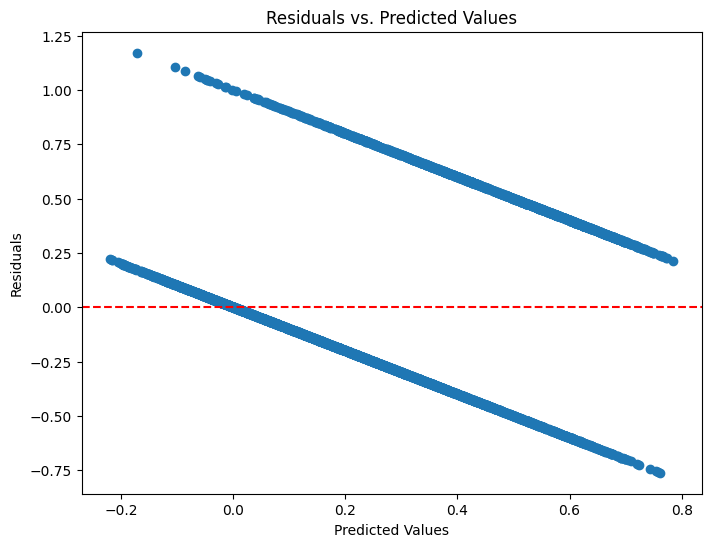

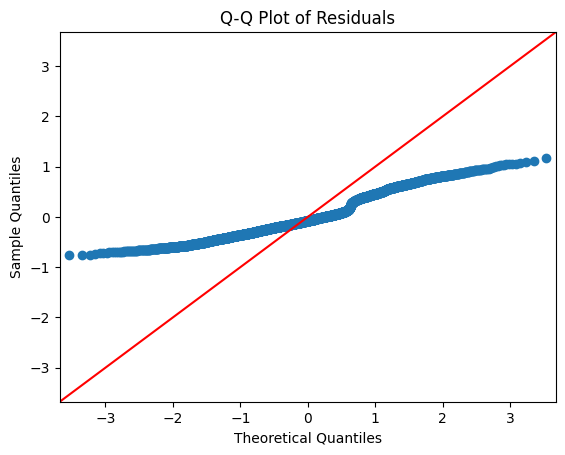

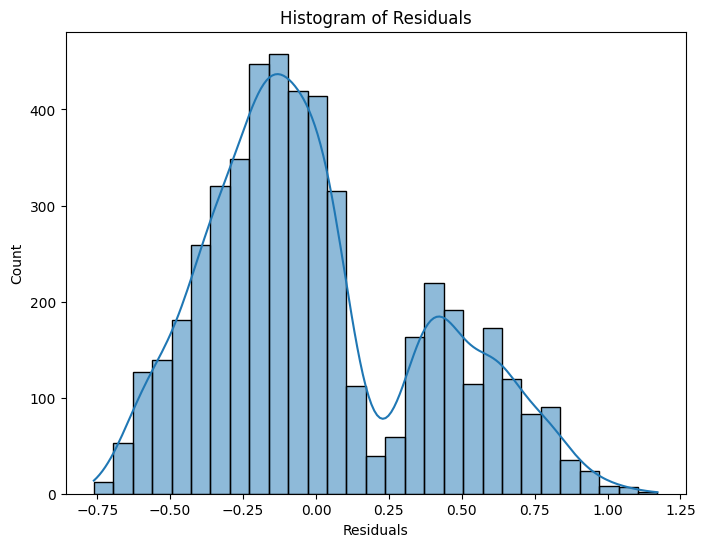

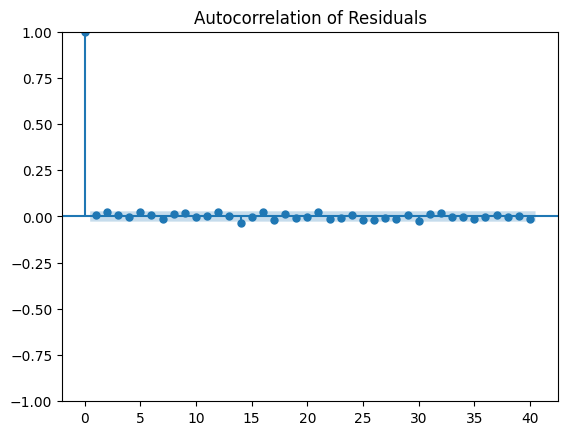

Durbin-Watson statistic: 1.9855870990144355
             Feature        VIF
0             gender   1.003040
1      SeniorCitizen   1.148480
2            Partner   1.456589
3         Dependents   1.382158
4             tenure   6.963381
5       PhoneService        inf
6      MultipleLines        inf
7    InternetService  13.703249
8     OnlineSecurity   3.996367
9       OnlineBackup   3.320459
10  DeviceProtection   3.788877
11       TechSupport   4.333928
12       StreamingTV   3.848876
13   StreamingMovies   3.895906
14          Contract   2.476689
15  PaperlessBilling   1.213095
16     PaymentMethod   1.214539
17    MonthlyCharges  16.512913
18      TotalCharges  10.400014


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [14]:
# Assumptions Check
# 1. Linear Assumption and Homogenous Assumption
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_train, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()

# 2. Assumption of Nomality
sm.qqplot(residuals, line='45')
plt.title('Q-Q Plot of Residuals')
plt.show()

# 3. Historgram of residuals to check normality
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.show()

# 4. Autocorrelation
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.title('Autocorrelation of Residuals')
plt.show()

# 5. Durbin-Watson statistic to test auto-correlation
dw_stat = sm.stats.stattools.durbin_watson(residuals)
print(f'Durbin-Watson statistic: {dw_stat}')

# 6. VIF
X_train_sm = sm.add_constant(X_train)
vif = pd.DataFrame()
vif['Feature'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train_sm.values, i) for i in range(1, X_train_sm.shape[1])]
print(vif)

1. Assumption of linearity is not satisfied. From figure 1, the relationship is non-linear
2. Assumption of homoscedasticity is not satisfied. From figure 1, the variance increases as value increase
3. Assumption of normality is not satisfied. From figure 2 and 3, the residuals do not follow normal distribution.
4. Assumption of auto-correlation and independence are satisfied. From figure 4 and DW statistic, we can see that the auto-correlation coefficients are most 0 and DW statistic is nearly 2
5. Many variables' VIF are higher than 5, which means they have multicollinearity. We will consider move them later.


## Model Analysis

In [15]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n{model_name}:")
    print(f"MSE: {mse:.2f}")
    print(f"R2 Score: {r2:.2f}")

    for feature, coef in zip(X.columns, model.coef_):
      print(f"{feature}: {coef:.4f}")

    return model, y_pred



In [16]:
# Fit models with three types of linear regression
lr_model, lr_pred = evaluate_model(LinearRegression(), X_train, X_test, y_train, y_test, "Linear Regression")
ridge_model, ridge_pred = evaluate_model(Ridge(alpha=1.0), X_train, X_test, y_train, y_test, "Ridge Regression")
lasso_model, lasso_pred = evaluate_model(Lasso(alpha=0.1), X_train, X_test, y_train, y_test, "Lasso Regression")



Linear Regression:
MSE: 0.14
R2 Score: 0.30
gender: -0.0127
SeniorCitizen: 0.0517
Partner: 0.0034
Dependents: -0.0193
tenure: -0.0012
PhoneService: 0.0012
MultipleLines: -0.0024
InternetService: 0.1909
OnlineSecurity: -0.0564
OnlineBackup: -0.0178
DeviceProtection: 0.0099
TechSupport: -0.0398
StreamingTV: 0.0368
StreamingMovies: 0.0770
Contract: -0.0476
PaperlessBilling: 0.0471
PaymentMethod: 0.0238
MonthlyCharges: -0.0002
TotalCharges: -0.0000

Ridge Regression:
MSE: 0.14
R2 Score: 0.30
gender: -0.0127
SeniorCitizen: 0.0517
Partner: 0.0034
Dependents: -0.0193
tenure: -0.0012
PhoneService: 0.0011
MultipleLines: -0.0023
InternetService: 0.1901
OnlineSecurity: -0.0564
OnlineBackup: -0.0177
DeviceProtection: 0.0099
TechSupport: -0.0398
StreamingTV: 0.0367
StreamingMovies: 0.0768
Contract: -0.0476
PaperlessBilling: 0.0471
PaymentMethod: 0.0238
MonthlyCharges: -0.0002
TotalCharges: -0.0000

Lasso Regression:
MSE: 0.15
R2 Score: 0.24
gender: -0.0000
SeniorCitizen: 0.0000
Partner: -0.0000
De

We compared Linear Regression, Ridge Regression, and Lasso Regression models:

Performance:

Linear and Ridge had the same performance with MSE = 0.14 and R² = 0.30, showing that regularization in Ridge had minimal effect.
Lasso performed slightly worse with MSE = 0.15 and R² = 0.24, likely due to its aggressive feature selection.

Coefficients:

Linear and Ridge had nearly identical coefficients, with key variables like InternetService and StreamingMovies being influential.
Lasso shrunk most coefficients to zero, keeping only tenure and MonthlyCharges as non-zero, highlighting fewer but more significant variables.

Conclusion:

Use Linear/Ridge for full feature analysis and better prediction.
Use Lasso for simpler models and feature selection.

In [17]:
# intercept
X_train_sm = sm.add_constant(X_train)

# OLS
ols_model = sm.OLS(y_train, X_train_sm).fit()

# print summary
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Churn   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     98.36
Date:                Wed, 18 Sep 2024   Prob (F-statistic):          4.12e-311
Time:                        18:54:39   Log-Likelihood:                -2190.1
No. Observations:                4930   AIC:                             4418.
Df Residuals:                    4911   BIC:                             4542.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0781      0.019  

1. Model Performance:
R-squared (0.265): The model explains 26.5% of the variance in churn, which is  low. This indicates that the model has limited explanatory power.
F-statistic (98.36, p-value ≈ 0): The model is statistically significant, meaning that at least one of the predictors significantly affects churn.
2. Key Coefficients:
SeniorCitizen (0.0517, p-value = 0.001): Being a senior citizen increases the likelihood of churn by 5.17% and is statistically significant.
InternetService (0.1909, p-value ≈ 0): It indicates that customers with internet service, particularly those using fiber optic, are significantly more likely to churn compared to those with no internet service. Fiber optic users have the highest churn risk, while DSL users also show a higher churn probability, though less than fiber optic users.
3. Non-significant Variables:
Gender (-0.0127, p-value = 0.239): Gender does not significantly affect churn.
Partner (0.0034, p-value = 0.793): Having a partner has no significant effect on churn.

This bar plot compares the coefficients of Linear Regression, Ridge, and Lasso models side by side. It helps visualize how regularization in Ridge and Lasso affects the coefficient values compared to standard linear regression.

<Figure size 1200x600 with 0 Axes>

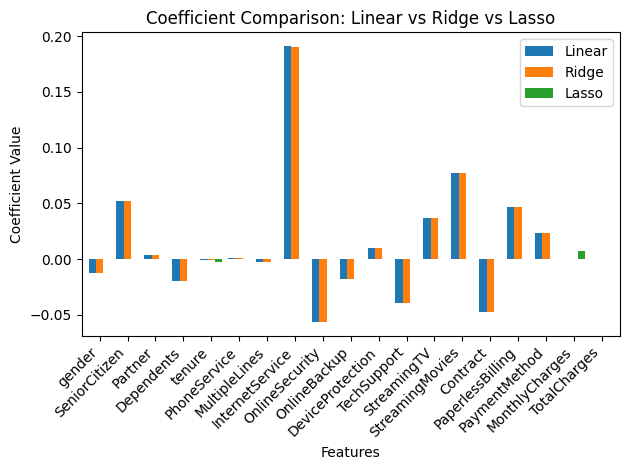

In [18]:
# Coefficient Comparison Plot
def plot_coefficients(lr_model, ridge_model, lasso_model):
    coef_df = pd.DataFrame({
        'Linear': lr_model.coef_,
        'Ridge': ridge_model.coef_,
        'Lasso': lasso_model.coef_
    }, index=X.columns)

    plt.figure(figsize=(12, 6))
    coef_df.plot(kind='bar', width=0.8)
    plt.title('Coefficient Comparison: Linear vs Ridge vs Lasso')
    plt.xlabel('Features')
    plt.ylabel('Coefficient Value')
    plt.legend(loc='best')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_coefficients(lr_model, ridge_model, lasso_model)

This heatmap visualizes the absolute values of coefficients across all three models. It provides a quick way to compare feature importances between models and identify which features have the strongest impact on predictions.

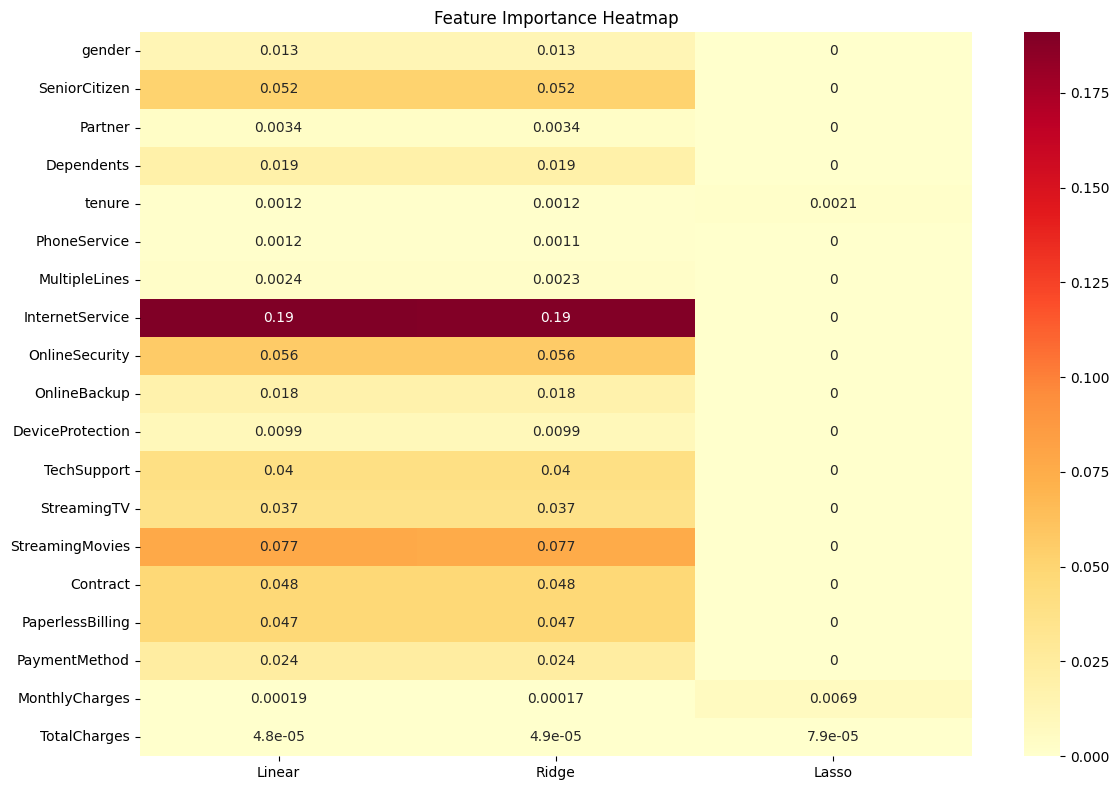

In [19]:
# Feature Importance Heatmap
def plot_feature_importance_heatmap(lr_model, ridge_model, lasso_model):
    importance_df = pd.DataFrame({
        'Linear': np.abs(lr_model.coef_),
        'Ridge': np.abs(ridge_model.coef_),
        'Lasso': np.abs(lasso_model.coef_)
    }, index=X.columns)

    plt.figure(figsize=(12, 8))
    sns.heatmap(importance_df, annot=True, cmap='YlOrRd')
    plt.title('Feature Importance Heatmap')
    plt.tight_layout()
    plt.show()

plot_feature_importance_heatmap(lr_model, ridge_model, lasso_model)

# Logistic regression part

## Coefficients interpretion

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Create and fit the logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Predict probabilities for the test set
y_pred = logreg.predict(X_test)

# Print model coefficients
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': logreg.coef_[0]})
print(coefficients)

# Evaluate the model
print(classification_report(y_test, y_pred))


             Feature  Coefficient
0             gender    -0.130787
1      SeniorCitizen     0.288475
2            Partner    -0.043844
3         Dependents    -0.233237
4             tenure    -0.062487
5       PhoneService    -0.233759
6      MultipleLines     0.063455
7    InternetService     0.232713
8     OnlineSecurity    -0.442716
9       OnlineBackup    -0.142426
10  DeviceProtection     0.018903
11       TechSupport    -0.369818
12       StreamingTV     0.165844
13   StreamingMovies     0.299840
14          Contract    -0.793747
15  PaperlessBilling     0.324298
16     PaymentMethod     0.105314
17    MonthlyCharges     0.001030
18      TotalCharges     0.000403
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1539
           1       0.66      0.58      0.62       574

    accuracy                           0.81      2113
   macro avg       0.76      0.74      0.74      2113
weighted avg       0.80      0.81      0.80     

SeniorCitizen: Coefficient 0.288475. Indicates senior citizens may be more likely in the target variable. For example, in predicting product purchase, seniors might due to higher consumption power or special needs.

OnlineSecurity: Coefficient -0.442716. Negative, suggesting customers with online security services may be less likely in the target variable.

PaperlessBilling: Coefficient 0.324298. Positive, meaning customers choosing paperless billing are more likely in the target variable.

## Assumption Test

### Linearity Test

In [21]:
# Adding interaction terms for Box-Tidwell test
X_train_log = X_train.copy()
continuous_features = ['tenure','MonthlyCharges',	'TotalCharges']
for col in continuous_features:  # Replace with the actual continuous feature names
    X_train_log[col + '_log'] = X_train[col] * np.log(X_train[col].replace(0, 0.1))  # Replace 0s with a small value

# Add a constant term for intercept
X_train_log_sm = sm.add_constant(X_train_log)

# Fit the logistic regression model
logit_model = sm.Logit(y_train, X_train_log_sm).fit()

# Print the summary to check significance (p-values)
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.413558
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 4930
Model:                          Logit   Df Residuals:                     4907
Method:                           MLE   Df Model:                           22
Date:                Wed, 18 Sep 2024   Pseudo R-squ.:                  0.2818
Time:                        18:54:56   Log-Likelihood:                -2038.8
converged:                       True   LL-Null:                       -2838.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.8852        nan        nan        nan         nan         nan
gende

tenure_log and MonthlyCharges_log are signficant which means they do not satisfy linearity. TotalCharges_log is non-significant which means it satisfy linearity.

### Multicollinearity test and independence test
Multicollinearity and independence have been tested in linear regression. Many variables suffer from multicollinearity. Independence is satisfied.

### Outlier Test


Optimization terminated successfully.
         Current function value: 0.419414
         Iterations 8


<ipython-input-22-be46c393f884>:11: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",", use_line_collection=True)


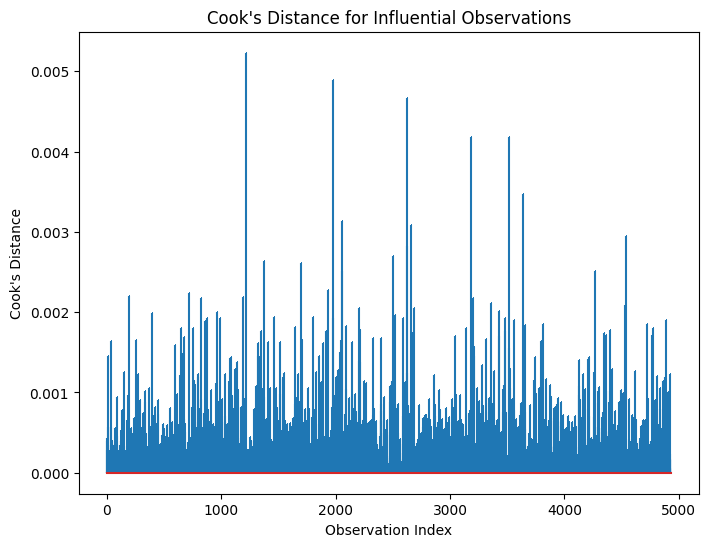

In [22]:
# Fit the logistic regression model using statsmodels
X_train_sm = sm.add_constant(X_train)
logit_model = sm.Logit(y_train, X_train_sm).fit()

# Cook's Distance
influence = logit_model.get_influence()
cooks_d = influence.cooks_distance[0]

# Plot Cook's Distance to detect influential outliers
plt.figure(figsize=(8, 6))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",", use_line_collection=True)
plt.title("Cook's Distance for Influential Observations")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.show()

All observations' cook distance are lower than 0.5, which means there are not outliers.

### Absence of perfect separation

Because all coefficient estimates are not too much high, we consider there is not perfect separation.

### Large Sample Size

In [23]:
n_cases = y_train.sum()
n_controls = len(y_train) - n_cases
n_predictors = X_train.shape[1]

print(f"Cases: {n_cases}, Controls: {n_controls}, Predictors: {n_predictors}")


Cases: 1295, Controls: 3635, Predictors: 19


Large sample size is satisfied as sample size is large compared to number of predictors.

# GAM Model（LogisticGAM)

In [24]:
X_train.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges'],
      dtype='object')

In [25]:
# Create a GAM model using smooth terms for continuous variables and factor terms for categorical variables
gam = LogisticGAM(
    s(4) +  # tenure (continuous variable, smooth term)
    s(17) + # MonthlyCharges (continuous variable, smooth term)
    s(18) + # TotalCharges (continuous variable, smooth term)
    f(0) +  # gender (categorical variable, factor term)
    f(1) +  # SeniorCitizen (categorical variable, factor term)
    f(2) +  # Partner (categorical variable, factor term)
    f(3) +  # Dependents (categorical variable, factor term)
    f(5) +  # PhoneService (categorical variable, factor term)
    f(6) +  # MultipleLines (categorical variable, factor term)
    f(7) +  # InternetService (categorical variable, factor term)
    f(8) +  # OnlineSecurity (categorical variable, factor term)
    f(9) +  # OnlineBackup (categorical variable, factor term)
    f(10) + # DeviceProtection (categorical variable, factor term)
    f(11) + # TechSupport (categorical variable, factor term)
    f(12) + # StreamingTV (categorical variable, factor term)
    f(13) + # StreamingMovies (categorical variable, factor term)
    f(14) + # Contract (categorical variable, factor term)
    f(15) + # PaperlessBilling (categorical variable, factor term)
    f(16)   # PaymentMethod (categorical variable, factor term)
)

# Fit the model
gam.fit(X_train, y_train)

# Predict probabilities and labels for the test set
y_pred = gam.predict(X_test)

# Evaluate the model's performance
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1539
           1       0.69      0.54      0.60       574

    accuracy                           0.81      2113
   macro avg       0.76      0.72      0.74      2113
weighted avg       0.80      0.81      0.80      2113



In [26]:
# Print model summary
print(gam.summary())

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     54.5913
Link Function:                        LogitLink Log Likelihood:                                 -1995.7163
Number of Samples:                         4930 AIC:                                             4100.6153
                                                AICc:                                            4101.9064
                                                UBRE:                                               2.8406
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                    0.297
Feature Function                  Lam

<ipython-input-26-c0a4b5d1307b>:2: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


1. Pseudo R-Squared (0.297):
The pseudo R-squared value of 0.297 suggests that the model explains approximately 29.7% of the variability in the target variable (churn). This indicates a moderate fit.

2. Smooth Terms (s) - Continuous Variables:

s(4) - Tenure:

Effective DoF: 13.4
P-value: 3.53e-04 (very significant, ***)
Interpretation: The relationship between tenure (how long the customer has been with the company) and churn is highly significant and non-linear. The high DoF (13.4) suggests a complex non-linear relationship, meaning that churn probability may change in a non-linear way as the tenure increases.

s(18) - TotalCharges:

Effective DoF: 10.7
P-value: 1.25e-01 (not significant)
Interpretation: The effect of TotalCharges on churn is not statistically significant in this model, suggesting that TotalCharges alone may not have a strong influence on churn.


3. Factor Terms (f) - Categorical Variables:

f(5) - PhoneService:

P-value: 4.79e-04 (very significant, ***)
Interpretation: Having phone service significantly impacts the likelihood of churn. The significance of this term suggests that customers with or without phone service have different probabilities of churning.

f(14) - Contract:

P-value: 1.25e-14 (very significant, ***)
Interpretation: The type of contract (monthly, one year, two years) is a highly significant predictor of churn. Customers with longer-term contracts (such as yearly or two-year contracts) are more likely to churn compared to those with month-to-month contracts.

4. Intercept:
P-value: 5.48e-05 (very significant, ***)
Interpretation: The intercept represents the baseline log-odds of churn when all predictors are at their reference values. A significant intercept indicates that even without the influence of predictors, there is a meaningful baseline churn rate in the data.

# Summary

1. Linear Regression:

Performance:
MSE: 0.14, R²: 0.30

Strength: Simple, easily interpretable.

Weakness: Poor fit for binary classification, not ideal for churn prediction due to linear assumptions.

Interpretability: Highly interpretable with direct, linear relationships between features and the target.

2. Ridge Regression:

Performance:
MSE: 0.14, R²: 0.30

Strength: Helps prevent overfitting with regularization.

Weakness: Assumes linearity, minimal improvement over logistic regression.

Interpretability: With regularization, reducing the direct interpretability of coefficients.
3. Lasso Regression:

Performance:
MSE: 0.15, R²: 0.24

Strength: Simplifies the model by removing irrelevant features.

Weakness: May discard important features, leading to lower predictive power.

Interpretability: Simplifies interpretation by shrinking irrelevant coefficients to zero, highlighting only the important features.
4. Logistic Regression:

Performance:
Accuracy: 0.81, Precision (class 1): 0.66, Recall (class 1): 0.58

Strength: Good for binary classification, interpretable.

Weakness: Assumes linearity, can't capture non-linear relationships.

Interpretability: Offers clear, interpretable coefficients for binary classification, representing the impact of each feature on the odds of churn.

5. Generalized Additive Model (GAM):

Performance:
Accuracy: 0.81, Precision (class 1): 0.69, Recall (class 1): 0.54

Strength: Best at modeling non-linear relationships, more flexible.

Weakness: More complex to interpret compared to linear/logistic regression.

Interpretability: Captures non-linear relationships but requires visualization to interpret feature effects, making it more complex to explain.

Summary:

For this binary classification task , GAM is the best choice. The linear assumption is not satisfied, and there is evidence of multicollinearity, which limits the effectiveness of linear and logistic regression models. GAM captures non-linear relationships and handles more complex patterns in the data, making it the most suitable model for predicting customer churn.

Future Improvements:

Address Multicollinearity: Remove or combine highly correlated features.

Handle Insignificant Variables: Eliminate or transform variables that do not significantly contribute to the model to improve efficiency.

Explore More Non-linear Combinations: Investigate additional non-linear interactions and feature transformations to further boost model performance.